In [10]:
%reload_ext autoreload
%autoreload 2

from ReviewModel import ReviewModel
from dataLoader import *

In [11]:
import numpy as np
import torch

In [12]:
import matplotlib.pyplot as plt
def plot_losses(tr_loss, val_loss):
    plt.plot(tr_loss, label="training")
    plt.plot(val_loss, label="validation")
    plt.legend()
    plt.show()

In [14]:
data_loader = AmznDataLoader( path ='./data/reviews_Amazon_Instant_Video_5.json.gz', maxSeqLength = 60)

In [15]:
ReviewModelParam = {
    "max_length": 60,
    "embedding_dim": 50,
    "vocab_length" : data_loader.weight_matrix.shape[0],
    "output_dim" : 5,
    "batch_size" : 128,
    
    "first_dropout" : 0.5,
    "conv_input_channel": None,
    "conv_output_channel" : 200,
    "conv_padding" : 2,
    "conv1_kernel_size" : 4,
    "conv2_kernel_size" : 5,
    "maxpool_kernel_size" : 2,
    "second_dropout" : 0.3,
    "rnn_input_size": None,
    "rnn_hidden_size" : 100,
    "rnn_num_layers" : 1,
    "first_dense_in":None,
    "first_dense_out" : 400,
    "third_dropout" : 0.15,
    "second_dense_in" : None,
    "second_dense_out" : None
    }

ReviewModelParam["conv_input_channel"] = ReviewModelParam["embedding_dim"]
ReviewModelParam["rnn_input_size"] = ReviewModelParam["conv_output_channel"]*2
ReviewModelParam["first_dense_in"] = ReviewModelParam["max_length"]//2 * ReviewModelParam["rnn_hidden_size"]
ReviewModelParam["second_dense_in"] = ReviewModelParam["first_dense_out"]
ReviewModelParam["second_dense_out"] = ReviewModelParam["output_dim"]  ##depends on loss function


In [19]:
from skorch import NeuralNetClassifier
import torch.optim as optim
from skorch.callbacks import EpochScoring,LRScheduler, EarlyStopping
from torch import nn

In [75]:
from torch.autograd import Variable
weight = Variable(torch.cuda.FloatTensor([0.4,0.5,0.11,0.23,0.56])) 

In [20]:
callbacks = [
    ('es1',EpochScoring('accuracy')),
    ('lrs',LRScheduler()),
    ('est',EarlyStopping()),
    
]
batch_size = 128
device = torch.device("cuda")
model = ReviewModel(ReviewModelParam).to(device)
#model = DynamicModel(batch_size,parameter_dict=SST1_DATASET_PARAMETERS).to(device)
net = NeuralNetClassifier(model,## change dimensionality
                          iterator_train__drop_last = True,
                          iterator_valid__drop_last = True, 
                          iterator_train__shuffle = True,
                          iterator_valid__shuffle = True,
                          max_epochs=100, 
                          criterion = nn.CrossEntropyLoss,
                          criterion__weight = weight, 
                          optimizer=optim.Adam,
                          lr = 0.01,
                          # optimizer__param_groups = {('momentum', 0.3)},
                          batch_size = batch_size,
                          callbacks = callbacks,
                          device = device,verbose = 1
                          )


In [21]:
inputs = torch.from_numpy(data_loader.X_train).long().to(device)
labels = torch.tensor(data_loader.y_train.values).long().to(device)
net.fit(inputs, labels)

  epoch    accuracy    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.5617        7.9445       0.5617        1.2027  77.0278
      2      0.5608        1.2027       0.5608        1.2035  76.4252
      3      0.5622        1.2026       0.5622        1.2025  76.0625
      4      0.5615        1.2028       0.5615        1.2033  76.4744
      5      0.5618        1.2031       0.5618        1.2033  76.4584
      6      0.5618        1.2024       0.5618        1.2019  76.0286
      7      0.5625        1.2018       0.5625        1.2020  76.1104
      8      0.5620        1.2025       0.5620        1.2029  76.0445
      9      0.5618        1.2020       0.5618        1.2026  76.0356
     10      0.5617        1.2021       0.5617        1.2017  76.1074
     11      0.5617        1.2022       0.5617        1.2018  76.0445
     12      0.5618        1.2041       0.5618        1.2023  76.0695
     13      0.5632 

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ReviewModel(
    (embedding): Embedding(52655, 50)
    (drop1): Dropout(p=0.5)
    (conv1): Conv1d(50, 200, kernel_size=(4,), stride=(1,), padding=(2,))
    (conv2): Conv1d(50, 200, kernel_size=(5,), stride=(1,), padding=(2,))
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop2): Dropout(p=0.3)
    (rnn): GRU(400, 100)
    (flatten): Flatten()
    (fc1): Linear(in_features=3000, out_features=400, bias=True)
    (drop3): Dropout(p=0.15)
    (fc2): Linear(in_features=400, out_features=5, bias=True)
  ),
)

In [34]:
inputs = torch.from_numpy(data_loader.X_test).long().to(device)
predictions = net.predict(inputs)

In [67]:
from sklearn.metrics import multilabel_confusion_matrix , confusion_matrix
conf1 = multilabel_confusion_matrix(data_loader.y_test[:-2], predictions)
conf2 = confusion_matrix(data_loader.y_test[:-2], predictions, labels=[0,1,2,3,4])

In [68]:
conf2

array([[   0,    0,    0,    0,  363],
       [   0,    0,    0,    0,  333],
       [   0,    0,    0,    0,  839],
       [   0,    0,    0,    0, 1687],
       [   0,    0,    0,    0, 4202]], dtype=int64)

In [71]:
import seaborn as sn; sn.set()
import numpy as np
sn.heatmap(conf2.astype(np.int32))
    

TypeError: super(type, obj): obj must be an instance or subtype of type

In [8]:
# save model
with open("model.pkl", 'wb') as f:
    pickle.dump("model",f)
   
# load model
with open("model.pkl","rb") as f: 
    model = pickle.load(f)

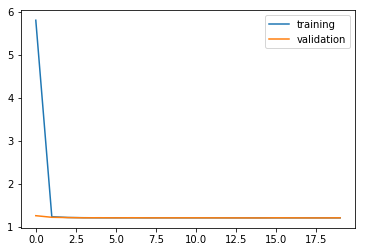

In [16]:
#todo plot losses
#todo plot accuracy
#todo confusion matrix
history = net.history
train_losses = history[:, 'train_loss']
valid_losses = history[:, 'valid_loss']

accuracy = history[:, 'accuracy']
plot_losses(train_losses, valid_losses)

In [ ]:
SST2_DATASET_PARAMETERS = {
    "cell_one_parameter_dict" : {
        "sent_length": 19,
        "conv_kernel_size": (7, 1),
        "conv_input_channels": 1,
        "conv_output_channels": 6,
        "conv_stride": (1, 1),
        "k_max_number": 10,
        "folding_kernel_size": (1, 2),
        "folding_stride": (1, 2)
    },
    "cell_two_parameter_dict" : {
        "sent_length": None,
        "conv_kernel_size": (5, 1),
        "conv_input_channels": 6,
        "conv_output_channels": 14,
        "conv_stride": (1, 1),
        "k_max_number": 4,
        "folding_kernel_size": (1, 2),
        "folding_stride": (1, 2)
    },
    "dropout_rate": 0.5,
    "embedding_dim": 50,
    "vocab_length": data_loader.weight_matrix,
    "output_dim": 2
}
SST2_DATASET_PARAMETERS["cell_two_parameter_dict"]["sent_length"] = SST2_DATASET_PARAMETERS["cell_one_parameter_dict"]["k_max_number"]

In [8]:
pickle.dump(weight_matrix,  open('./data/GloveMatrix.npy', 'wb'))

In [9]:
from collections import Counter
c = Counter(data_loader.y_train)

In [10]:
[(i, c[i]/len(data_loader.y_train)*100) for i in c]

[(3.0, 22.757575757575758),
 (4.0, 56.18518518518518),
 (0.0, 4.562289562289562),
 (2.0, 11.26936026936027),
 (1.0, 5.225589225589226)]

In [11]:
weight = Variable(torch.cuda.FloatTensor([0.4,0.5,0.11,0.23,0.56])) 

In [12]:
from skorch.callbacks import EpochScoring,LRScheduler, EarlyStopping

In [13]:
# from sklearn.model_selection import GridSearchCV

In [16]:
# params = {
#     'lr': [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9],
#     'max_epochs': list(range(10,100,20))
# }
# gs = GridSearchCV(net, params, refit = False, scoring = 'accuracy',verbose = 1)


In [20]:
inputs = torch.from_numpy(data_loader.X_train).long().to(device)
labels = torch.tensor(data_loader.y_train.values).long().to(device)
net.fit(inputs, labels)

RuntimeError: CUDA error: device-side assert triggered

In [ ]:
# save model
with open("model.pkl", 'wb') as f:
    pickle.dump("model",f)
    
    

In [ ]:
with open("model.pkl","rb") as f: 
    model = pickle.load(f)

In [ ]:
import matplotlib.pyplot as plt
def plot_losses(tr_loss, val_loss):
    plt.plot(tr_loss, label="training")
    plt.plot(val_loss, label="validation")
    plt.legend()
    plt.show()

In [ ]:
#todo plot losses
#todo plot accuracy
#todo confusion matrix
history = net.history
train_losses = history[:, 'train_loss']
valid_losses = history[:, 'valid_loss']

accuracy = history[:, 'accuracy']
plot_losses(train_losses, valid_losses)

In [49]:
SST1_DATASET_PARAMETERS = {
    "cell_one_parameter_dict" : {
        "sent_length": 60,
        "conv_kernel_size": (10, 1),
        "conv_input_channels": 1,
        "conv_output_channels": 6,
        "conv_stride": (1, 1),
        "k_max_number": 9,
        "folding_kernel_size": (1, 2),
        "folding_stride": (1, 2)
    },
    "cell_two_parameter_dict" : 
        "sent_length": None,
        "conv_kernel_size": (7, 1),
        "conv_input_channels": 6,
        "conv_output_channels": 12,
        "conv_stride": (1, 1),
        "k_max_number": 5,
        "folding_kernel_size": (1, 2),
        "folding_stride": (1, 2)
    },
    "dropout_rate": 0.5,
    "embedding_dim": 50,
    "vocab_length": data_loader.weight_matrix.shape[0],
    "output_dim": 5
}
SST1_DATASET_PARAMETERS["cell_two_parameter_dict"]["sent_length"] = SST1_DATASET_PARAMETERS["cell_one_parameter_dict"]["k_max_number"]
